In [ ]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools 
from collections import Counter
import warnings

import os

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\[\d{1,2}/\d{1,2}/\d{2},\s\d{1,2}:\d{2}:\d{2}\s[APap][mM]\]\s',
        '24hr' : '\[\d{1,2}/\d{1,2}/\d{2},\s\d{1,2}:\d{2}:\d{2}\]\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '[%d/%m/%y, %I:%M:%S %p] ',
        '24hr' : '[%d/%m/%y, %H:%M:%S] ',
        'custom': ''
    }

    
    with open(file, 'r', encoding='utf-8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) 
        user_msg = re.split(split_formats[key], raw_string) [1:] 
        date_time = re.findall(split_formats[key], raw_string)
        
        print(f'raw_string length: {len(raw_string)}')
        print(f'user_msg length: {len(user_msg)}')
        print(f'date_time length: {len(date_time)}')
        
        if len(user_msg) != len(date_time):
            print('Mismatch between user_msg and date_time lengths')
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg})
        
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) 
        if a[1:]: 
            usernames.append(a[1])
            msgs.append(a[2])
        else: 
            print(f'Unexpected format for i: {i}')
            usernames.append("group_notification")
            msgs.append(a[0])

    df['user'] = usernames
    df['message'] = msgs

    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [ ]:
df = rawToDf('cb_chat.txt', '12hr')

In [ ]:
df['hour'] = df['date_time'].apply(lambda x: x.hour)
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

In [ ]:
df.to_clipboard()

In [ ]:
rename_users = pd.read_csv('rename_users.csv')

In [ ]:
df = pd.merge(df,rename_users,on='user',how='left')

In [ ]:
df.to_pickle('whatsapp_chat_formatted.pkl')

In [ ]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
# df1 = df1[df1['is_active'] == 1]
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
# df1 = df1.groupby('date').sum().reset_index()  
df1 = df1.groupby('date')['message_count'].sum().reset_index() # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1.to_pickle('df_daily_messages.pkl')

In [ ]:
# Count of messages per user
df_no_of_messages = df.groupby('name').message.count().reset_index()

df_no_of_messages.columns = ['name', 'number_of_msgs']

df_no_of_messages.to_pickle('df_no_of_messages.pkl')

In [ ]:
# Top 10 most active days
df2 = df.copy()      
# df2 = df2[df2['is_active'] == 1]
df2['message_count'] = [1] * df2.shape[0] 
df2.drop(columns='year', inplace=True)    
df2 = df2.groupby('date')['message_count'].sum().reset_index() 

df_top10days = df2.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
df_top10days.reset_index(inplace=True)           # reset index in order.
df_top10days.drop(columns="index", inplace=True) # dropping original indices.

df_top10days.to_pickle('df_top10days.pkl')

In [ ]:
# Most used emoji

emoji_ctr = Counter()
emojis_dict = emoji.get_emoji_unicode_dict('en')
emojis_list = map(lambda x: ''.join(x.split()), emojis_dict.values())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    emojis_found = r.findall(row["message"])
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1

df_top10emojis = pd.DataFrame()
# top10emojis = pd.DataFrame(data, columns={"emoji", "emoji_description", "emoji_count"}) 
df_top10emojis['emoji'] = [''] * 10
df_top10emojis['emoji_count'] = [0] * 10
df_top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # will be using another helper column, since during visualization, the emojis won't be rendered.
    description = emoji.demojize(item[0])[1:-1]    # using `[1:-1]` to remove the colons ':' at the end of the demojized strin
    
    # appending top 10 data of emojis.  # Loading into a DataFrame.
    df_top10emojis.emoji[i] = item[0]
    df_top10emojis.emoji_count[i] = int(item[1])
    df_top10emojis.emoji_description[i] = description
    i += 1

df_top10emojis.to_pickle('df_top10emojis.pkl')


In [ ]:
# Messages by hour of the day
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

df_by_hour = df3.groupby('hour')['message_count'].sum().reset_index().sort_values(by = 'hour')

df_by_hour.to_pickle('df_by_hour.pkl')

# Messages by day
df_by_day = df3.groupby('day')['message_count'].sum().reset_index().sort_values(by = 'day')
df_by_day.to_pickle('df_by_day.pkl')

# Messages by month
df_by_month = df3.groupby('month')['message_count'].sum().reset_index().sort_values(by = 'month')
df_by_month.to_pickle('df_by_month.pkl')

In [ ]:
# comment_words = ' '

# # stopwords --> Words to be avoided while forming the WordCloud,
# # removed group_notifications like 'joined', 'deleted';
# # removed really common words like "yeah" and "okay".
# stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted','image'])


# # iterate through the DataFrame.
# for val in df3.message.values:
    
#     # typecaste each val to string.
#     val = str(val) 
    
#     # split the value.
#     tokens = val.split() 
    
#     # Converts each token into lowercase.
#     for i in range(len(tokens)): 
#         tokens[i] = tokens[i].lower() 
          
#     for words in tokens: 
#         comment_words = comment_words + words + ' '
  
  
# wordcloud = WordCloud(width = 600, height = 600, 
#                 background_color ='white', 
#                 stopwords = stopwords, 
#                 min_font_size = 8).generate(comment_words) 

In [ ]:
df['group_name'] = df['message'].str.extract('changed the subject to “([^”]*).*')
df_group_name = df[df['message'].str.contains('subject to', na=False)]
df_group_name['name'] = df_group_name['name'].fillna('Vikram')

df_group_name.to_pickle('df_group_name.pkl')

In [ ]:
import os
import datetime

file_path = "cb_chat.txt"  # replace with your file path

# Get file creation time
creation_time = os.path.getctime(file_path)

# Convert to readable timestamp
creation_date = datetime.datetime.fromtimestamp(creation_time)

print("File Created: " + str(creation_date))


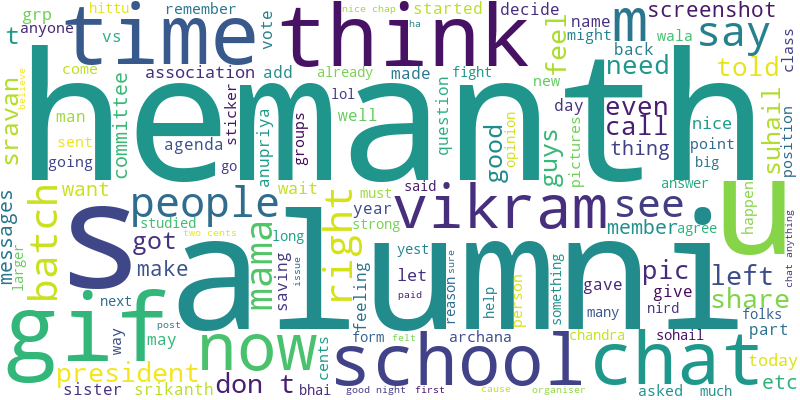

In [32]:
whatsapp_chat_formatted = pd.read_pickle('whatsapp_chat_formatted.pkl')

desired_date = pd.to_datetime('2022-04-26')  # Adjust the format if needed
df_top_msgs = whatsapp_chat_formatted[whatsapp_chat_formatted['date_time'].dt.date == desired_date.date()]


STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 
                  'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 
                  'guy', 'group', 'media', 'omitted','image'])
stopwords = STOPWORDS

# Generate comment_words using a generator expression and str.join()
comment_words = ' '.join(word for message in df_top_msgs.message for word in str(message).lower().split())

wordcloud = WordCloud(width = 800, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)

wordcloud.to_image()

In [30]:
# Count the number of messages for each date
message_counts = whatsapp_chat_formatted['date_time'].dt.date.value_counts().sort_index()

# Print the count for '2023-04-16'
print("Number of messages on 2022-04-26:", message_counts.get(pd.to_datetime('2022-04-26').date()))


Number of messages on 2022-04-26: 493
